<a href="https://colab.research.google.com/github/wsilveira-splunk/channel_capacity/blob/master/channel_capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import trapz

In [102]:
snr_db = list(range(-8, 31, 1))
snr = list(map(lambda x: pow(10, (x/10)), snr_db))
C_gaussian_ch = list(map(lambda x: 0.5*math.log2(1+x), snr))

p = list(map(lambda x: 0.5*math.erfc(math.sqrt(x/2)), snr))
C_bsc = list(map(lambda x: 1 - (x*math.log2(1/x)+(1-x)*math.log2(1/(1-x))), p))
#C_2pam = list(map(lambda x: (2*x+math.log2(16*math.pi/x)-0.5*math.log2(2*math.pi*math.e/x)), snr))

In [159]:
x_min = -10.0
x_max = 10.0
x_int = np.linspace(x_min, x_max, 1001)

P_2pam = 1
Pn = list(map(lambda x: P_2pam/x, snr))
C_2pam = []

for Pn_at_snr in Pn:
  y_minus_1 = scipy.stats.norm.pdf(x_int,-1,math.sqrt(Pn_at_snr))
  y_plus_1 = scipy.stats.norm.pdf(x_int,1,math.sqrt(Pn_at_snr))

  sum_gaussians = []
  for idx in range(len(y_plus_1)):
      sum_gaussians.append((y_minus_1[idx] + y_plus_1[idx]) / 2)
  
  h_y_integrand = [] 
  for sum_gaussians_idx in sum_gaussians:
      h_y_integrand.append(sum_gaussians_idx * math.log2(1/sum_gaussians_idx))

  h_y = trapz(h_y_integrand, x_int) - 0.5*math.log2(2*math.pi*math.e*Pn_at_snr)
  C_2pam.append(h_y)

print(C_2pam)

[0.10357795469644371, 0.13064498621878995, 0.1613663891586703, 0.19772673768021187, 0.24074715677558434, 0.2910364211626555, 0.34887885452937706, 0.4141114155290766, 0.48594415413293524, 0.5627881377586503, 0.6421486455923668, 0.7206608886660602, 0.7943534166511295, 0.8591940837493408, 0.9118804545871195, 0.9506811069257156, 0.9759799743828992, 0.9901635923434551, 0.9967563279900296, 0.9991842689878998, 0.9998539162039876, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars


In [193]:
x_min = -20.0
x_max = 20.0
x_int = np.linspace(x_min, x_max, 1001)

def gaussian_dist(x_int, u, std):

  var = float(std)**2
  den = (2*math.pi*var)**.5
  gaussian_dist_pdf = list(map(lambda x: (math.exp(-(float(x)-float(u))**2/(2*var)))/den, x_int))

  return gaussian_dist_pdf

def mutual_info_mpam(m):

  P_mpam = ((len(m)**2)-1)/3
  Pn = list(map(lambda x: P_mpam/x, snr))

  C_mpam = []
  
  for Pn_at_snr in Pn:
    
    y_gaussians = []
    y_gaussians = list(map(lambda x: scipy.stats.norm.pdf(x_int,x,math.sqrt(Pn_at_snr)), m))
    #y_gaussians = list(map(lambda x: gaussian_dist(x_int,x,math.sqrt(Pn_at_snr)), m))

    sum_gaussians = []
    for idx in range(len(y_gaussians[0])):

      sum = 0
      for gaussian_idx in range(len(m)):
        sum += y_gaussians[gaussian_idx][idx]

      sum_gaussians.append(sum/len(m))

    h_y_integrand = [] 
    for sum_gaussians_idx in sum_gaussians:
        h_y_integrand.append(sum_gaussians_idx * math.log2(1/sum_gaussians_idx))

    mutual_info = trapz(h_y_integrand, x_int) - 0.5*math.log2(2*math.pi*math.e*Pn_at_snr)
    C_mpam.append(mutual_info)

  return C_mpam

m = [-1, 1]
C_2pam = mutual_info_mpam(m)
m = [-3, -1, 1, 3]
C_4pam = mutual_info_mpam(m)
m = [-7, -5, -3, -1, 1, 3, 5, 7]
C_8pam = mutual_info_mpam(m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


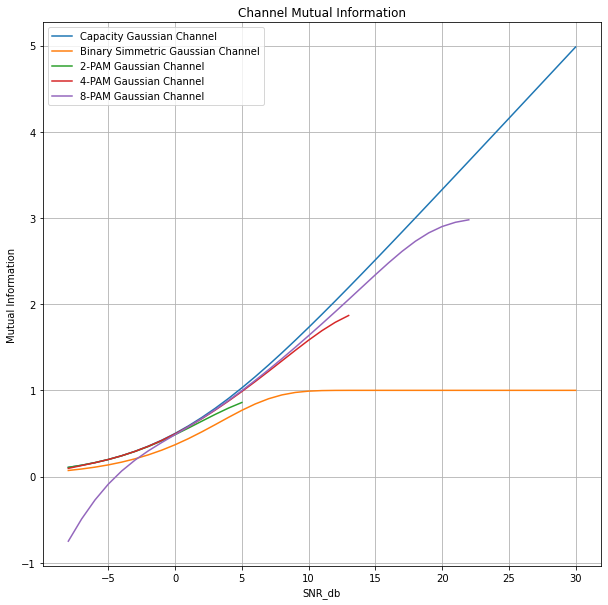

In [194]:
plt.figure(figsize=(10,10)) 
plt.plot(snr_db, C_gaussian_ch, label='Capacity Gaussian Channel') 
plt.plot(snr_db, C_bsc, label='Binary Simmetric Gaussian Channel')
plt.plot(snr_db, C_2pam, label='2-PAM Gaussian Channel')
plt.plot(snr_db, C_4pam, label='4-PAM Gaussian Channel')
plt.plot(snr_db, C_8pam, label='8-PAM Gaussian Channel')
plt.title('Channel Mutual Information')
plt.xlabel('SNR_db')
plt.ylabel('Mutual Information')
plt.legend()
plt.grid(True)
plt.show()